In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'handwritten-characters:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F53376%2F101598%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T154116Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2cec6252b366712a65bbed4cdfb7d61a9464e5c5e3b70ffbed00ac5a878ad054f9dfcfa9666ceb2d96b7a5584c593b311103b4f773d9bf5629356d4845d1aa206b42ffe73ccd0a25308a2e749e206de3a33c25ae14addc94fd6e6729d701e86220f9fc6faf09693dfc171043e79115ae1b99ed191a9b5f55bdcc4608af9c08b4a044fe482cf96a12d9b4cd8c0d17edcbcf12778ae0dc9704411fe209f96402d212604f52cb0ad66bf182cd35476ff8332b74843e73cf3404cdd33382bb1848f7b6d4d6b34af4af2c72b4613b1fdc5479b1db3e0c33990399d789eb8a78ddd94bbf723b5f3837f37c8be8158afb154c38a3938dcb4562f024db290e2b663a3d6a,handwriting-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F818027%2F1400106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T154116Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5cd4856b81b2ba5fcbfa57a5c7be555df544369c79bf478005e37236d8ed6952cf150114f65cd6ed8a112a6f0c7f75d4d83d87bc5a9f67aa441b1463a9d830a4242d1be6d3b7b7de3ba9890455e537a7522303c7cdc4d98160ce72c0c8a651bebaaab94aa3535d00353906de182d02c17dad5b8fee6b663ab993f99910d5492fc7324c39c44c0917c0afd5d3777dc1eefa9c92a75ab299d96aab6476a01d60630a1f9ba6cc274c7487c69cc6e03a5e68776da18287e93d9d78604970477e6f01de6c030e6e3e973dd23a1f09a2325500bf088e18396eaabcf756e2df4960b8e5a2d228f1841ec41a49c36f91c9f2a0f9bab1bd7bdb1bf7bd6d68c084da4d5fbf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1740501298 bytes downloaded
Downloaded and uncompressed: handwritten-characters
[==================================================] 1353071625 bytes downloaded
Downloaded and uncompressed: handwriting-recognition
Data source import complete.


In [2]:
!pip install imutils

In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [4]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [5]:
len(train_data)

140000

In [6]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [7]:
len(val_data)

15209

In [8]:
random.shuffle(train_data)
random.shuffle(val_data)

In [9]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [10]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [11]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [12]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [13]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [14]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [15]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [18]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [30]:
history = model.fit(train_X,train_Y, epochs=1, batch_size=128, validation_data = (val_X, val_Y),  verbose=1)

1094/1094 [==============================] - 204s 186ms/step - loss: 0.1612 - accuracy: 0.9392 - val_loss: 0.2295 - val_accuracy: 0.9255


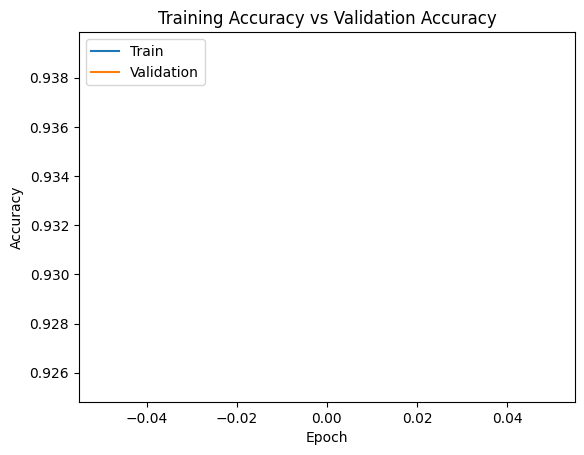

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

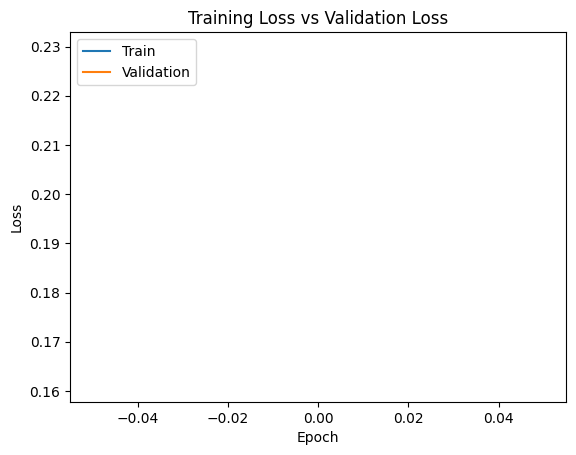

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [35]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

#plt.imshow(image)

In [36]:
def get_word(letter):
    word = "".join(letter)
    return word

1/1 [==============================] - 0s 36ms/step
MWV


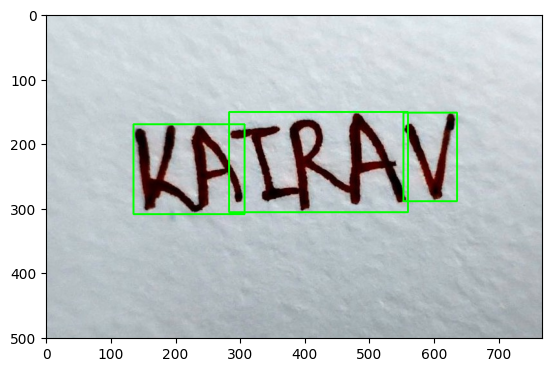

In [37]:
letter,image = get_letters("/content/1 (1).jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 22ms/step
ADIA


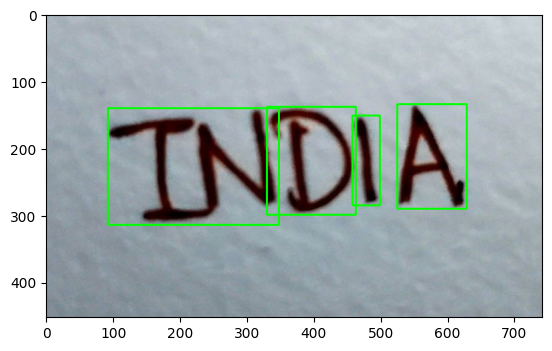

In [38]:
letter,image = get_letters("/content/1 (10).jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

In [39]:
letter,image = get_letters("/content/1 (11).jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 21ms/step


TypeError: can only concatenate str (not "int") to str

1/1 [==============================] - 0s 22ms/step
WMVWVSQX


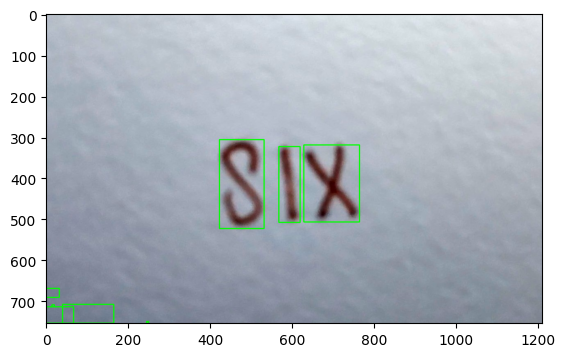

In [40]:
letter,image = get_letters("/content/1 (12).jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

In [42]:
letter,image = get_letters("/content/WhatsApp Image 2024-04-29 at 00.29.20_eefbbc96.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 32ms/step


TypeError: can only concatenate str (not "int") to str